In [1]:
import numpy as np
from numpy.random import choice, randint, rand, uniform

import pdb

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils.random import erdos_renyi_graph
from torch_geometric.utils import to_dense_adj, to_networkx, to_undirected

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import networkx as nx
import gym
from gym.spaces import Box, MultiDiscrete

from collections import namedtuple
from copy import copy, deepcopy
from typing import Optional
from enum import Enum, IntEnum
import sys
sys.path.append('/home/victorialena/rlkit')

import rlkit
from path_collector import MdpPathCollector

from any_replay_buffer import anyReplayBuffer

In [2]:
import time
start_time = time.time()

### env

In [3]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [4]:
sysconfig = namedtuple("sysconfig", 
                       ['maxX', 'maxY', 'goal_reward', 'collision_penalty', 'distance_penalty'], 
                       defaults=[5, 5, 1., -.1, -.02])

In [5]:
actions = namedtuple("actions", 
                    ['right', 'left', 'up', 'down', 'noop'], 
                    defaults=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)])
action = actions()
a2vecmap = torch.Tensor([[1., 0.],
                         [-1, 0.],
                         [0., 1.],
                         [0, -1.],
                         [0., 0.]]).to(device)

In [6]:
def fully_connect_graph(n_drones):
    """ Connect the graph s.t. all drones are interconnected and each goal connects to all drones. """
    
    idx = torch.combinations(torch.arange(n_drones+1), r=2)
    return to_undirected(idx.t(), num_nodes=n_drones+1)

def connect_graph(n_drones, n_goal):
    """ Connect the graph s.t. all drones are interconnected and each goal connects to all drones. """
    
    idx = torch.combinations(torch.arange(n_drones), r=2)
    edge_index = to_undirected(idx.t(), num_nodes=n_drones)

    arr = torch.arange(n_drones, n_drones+n_goal)
    for i in range(n_drones):
        drone2goal = torch.stack([arr, i*torch.ones(n_goal, dtype=torch.int64)])
        edge_index = torch.hstack((edge_index, drone2goal))
    return edge_index

In [15]:
class droneDeliveryProbe(gym.Env):
    """
    ### Description
    
    ### Action Space
    Each agent in the scene can move R or L or not at all.
    
    ### State Space
    The state is defined as an arbitrary input array of positions of n drones, appended by the location
    of the goal region.
    
    ### Rewards
    The reward of +1 is given to the system for each drone reaching the goal region.
    
    ### Starting State
    Randomly initilized input array.
    
    ### Episode Termination
    When all drones have reached the goal region.
    
    ### Arguments
    No additional arguments are currently supported.
    """

    def __init__(self, n, m, device='cpu'):
        self.config = sysconfig()
        self.ndrones = n
        self.ngoals = m
        
        self.aspace = MultiDiscrete([len(action)]*self.ndrones)
        self.sspace = MultiDiscrete([self.config.maxX, self.config.maxY, 2])
        self.state = None
        
        self._device = device
        
    def get_distances(self):
        dis = torch.cdist(self.state.x[:self.ndrones, :-1], self.state.x[-self.ngoals:, :-1], p=1)
        return dis.min(1).values
    
    def in_collision(self):
        dis = torch.cdist(self.state.x[:self.ndrones, :-1], self.state.x[:self.ndrones, :-1], p=1)
        return torch.triu((dis == 0).float(), 1).sum().item()
    
    def get_size(self):
        return torch.Tensor([self.config.maxX, self.config.maxY, 2])
    
    def is_terminal(self):
        return (self.get_distances() == 0).all()
        
    def reward(self, a):
        done = self.is_terminal().float().item()
        return self.config.goal_reward * done + \
                self.config.collision_penalty * self.in_collision() * (1 - done) + \
                self.config.distance_penalty * env.get_distances() #.sum().item()
                        
    def step(self, a):
        err_msg = f"{a!r} ({type(a)}) is not a valid action."
        assert self.aspace.contains(a), err_msg
        
        reward = self.reward(a)
        a = a2vecmap[a]
        done = self.is_terminal().item()   
    
        self.state.x[:self.ndrones, :-1] = (self.state.x[:self.ndrones, :-1]+a).clamp(min=0, max=self.config.maxX)
        
        return deepcopy(self.state), deepcopy(reward), deepcopy(done), {}

    def reset(self, seed: Optional[int] = None):
        if not seed == None:
            super().reset(seed=seed)
            
        x = torch.Tensor(np.stack([self.sspace.sample() for _ in range(self.ndrones+self.ngoals)]))
        # reset the state flags: +1 agent, -1 goal
        x[:, -1] = 1
        x[self.ndrones:, -1] = -1
        
        edge_index = connect_graph(self.ndrones, self.ngoals)
        self.state = Data(x=x, edge_index=edge_index).to(device)
        
        return deepcopy(self.state)

    def render(self, s = None):
        if not s:
            s = self.state
        g = torch_geometric.utils.to_networkx(s, to_undirected=False)
        colors = np.array(['green']*self.ndrones+['yellow']*self.ngoals)
        pos = {i: x[:2].cpu().numpy() for i, x in enumerate(self.state.x)}
        nx.draw(g, pos=pos, node_color=colors)
    
    def seed(self, n: int):
        super().seed(n)
        self.aspace.seed(n)
        self.sspace.seed(n)
        
    def to(self, device):
        self._device = device
        if self.state:
            self.state = self.state.to(device)

In [8]:
ndrones = 2
ngoals = 2

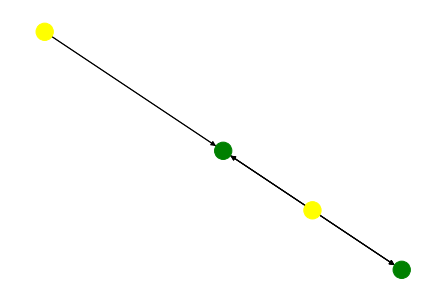

In [16]:
env = droneDeliveryProbe(ndrones, ngoals, device=device)
x = env.reset()

env.render()

### Model

In [17]:
from collections import OrderedDict

from torch.nn import Linear, ReLU, LeakyReLU, Softmax
import torch.nn.functional as F
from torch_geometric.nn import Sequential, GCNConv, SAGEConv
        
class droneDeliveryModel(nn.Module):
    
    def __init__(self, n, c_in, c_out, c_hidden=[], bounds=None, **kwargs):
        
        super().__init__()
        
        activation_fn = kwargs['activation'] if 'activation' in kwargs.keys() else ReLU(inplace=True)
        
#         self.model = Sequential('x, edge_index', [
#             (SAGEConv(c_in, c_hidden), 'x, edge_index -> x'),
#             activation_fn,
#             (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
#             activation_fn,
#             (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
#             activation_fn,
#             Linear(c_hidden, c_out),
# #             nn.Softmax(dim=-1) # no freaking softmax
#         ])
        assert len(c_hidden) > 0, "Hidden dimension can not be zero => no GCN layer."
        layer_size = [c_in]+c_hidden
        
        self.model = Sequential('x, edge_index', [
            x for _in, _out in zip(layer_size[:-1], layer_size[1:]) 
              for x in [(SAGEConv(_in, _out), 'x, edge_index -> x'), 
                        activation_fn]] +
            [Linear(layer_size[-1], c_out),]
        )
        
        self._device = 'cpu'
        self._upper_bound = bounds
        self._n = n

    def forward(self, x):
        y = x.x
        if self._upper_bound is not None:
            y = y.div(self._upper_bound-1)
        return self.model(y, x.edge_index)[:self._n]
    
    def to(self, device):
        super().to(device)
        self._device = device
        if self._upper_bound is not None:
            self._upper_bound = self._upper_bound.to(device)

In [18]:
in_channels, out_channels = 3, len(action)

In [20]:
qf = droneDeliveryModel(ndrones, in_channels, out_channels, [32, 32, 16], bounds=env.get_size())#, activation=LeakyReLU(inplace=True))

In [21]:
qf

droneDeliveryModel(
  (model): Sequential(
    (0): SAGEConv(3, 32)
    (1): ReLU(inplace=True)
    (2): SAGEConv(32, 32)
    (3): ReLU(inplace=True)
    (4): SAGEConv(32, 16)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

### RL 

In [22]:
max_len = env.config.maxX + env.config.maxY - 1

In [23]:
def pick(x):
    probs = np.array([x[0]>0, x[0]<0, x[1]>0, x[1]<0, x[1]==x[0]==0], dtype=int)
    return np.random.choice(action, p=probs/sum(probs))

In [27]:
from rlkit.policies.base import Policy

class sysRolloutPolicy(nn.Module, Policy):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def get_action(self, obs):
        idx = torch.cdist(obs.x[:self.n, :-1], obs.x[self.n:, :-1], p=1).min(1).indices
#         pdb.set_trace()
        dis = (obs.x[idx+self.n, :-1] - obs.x[:self.n, :-1])
        return [pick(d.cpu()) for d in dis], {}
    
class argmaxDiscretePolicy(nn.Module, Policy):
    def __init__(self, qf, dim=1):
        super().__init__()
        self.qf = qf
        self.dim = dim

    def get_action(self, obs):
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

# redundant code - clean this up
class epsilonGreedyPolicy(nn.Module, Policy):
    def __init__(self, qf, space, eps=0.1, dim=1, sim_annealing_fac=1.0, minimum=0.0):
        super().__init__()
        self.qf = qf
        self.aspace = space
        
        self.eps = eps
        self.dim = dim
        self.saf = sim_annealing_fac
        self.min = minimum
        
    def simulated_annealing(self):
        self.eps = max(self.min, self.eps*self.saf)

    def get_action(self, obs):
        if rand() < self.eps:
            return self.aspace.sample(), {}
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

In [33]:
def mean_reward_per_traj(paths):
    return np.mean([torch.vstack(p['rewards']).sum().item() for p in paths])

def mean_reward(paths):
    return torch.hstack([torch.vstack(p['rewards']).sum(1) for p in paths]).mean().item()

###### For unified reward
```python
def mean_reward_per_traj(paths):
    return np.mean([np.sum(p['rewards']) for p in paths])

def mean_reward(paths):
    return np.hstack([p['rewards'] for p in paths]).mean()
```

In [34]:
example_policy = sysRolloutPolicy(ndrones) 
path_collector = MdpPathCollector(env, example_policy)
paths = path_collector.collect_new_paths(100, max_len, False)
expected_heuristic_pt = mean_reward_per_traj(paths)
print("Expected reward (per traj):", expected_heuristic_pt)
expected_heuristic = mean_reward(paths)
print("Expected reward (per step):", expected_heuristic, '\n')

idx = np.random.randint(100)
for s, a, r, t in zip(paths[idx]['observations'], paths[idx]['actions'], 
                      paths[idx]['rewards'], paths[idx]['terminals']):
    print('\n', s.x)
    print(a)
    print(r)
    print(t)

Expected reward (per traj): 1.7770000457763673
Expected reward (per step): 0.4302663803100586 


 tensor([[ 4.,  2.,  1.],
        [ 2.,  1.,  1.],
        [ 3.,  2., -1.],
        [ 0.,  1., -1.]], device='cuda:0')
[1, 2]
tensor([-0.0200, -0.0400], device='cuda:0')
False

 tensor([[ 3.,  2.,  1.],
        [ 2.,  2.,  1.],
        [ 3.,  2., -1.],
        [ 0.,  1., -1.]], device='cuda:0')
[4, 0]
tensor([ 0.0000, -0.0200], device='cuda:0')
False

 tensor([[ 3.,  2.,  1.],
        [ 3.,  2.,  1.],
        [ 3.,  2., -1.],
        [ 0.,  1., -1.]], device='cuda:0')
[4, 4]
tensor([1., 1.], device='cuda:0')
True


In [38]:
qf = droneDeliveryModel(ndrones, in_channels, out_channels, [32, 16], bounds=env.get_size())
qf.to(device)

In [39]:
example_policy = argmaxDiscretePolicy(qf) 
path_collector = MdpPathCollector(env, example_policy)
paths = path_collector.collect_new_paths(100, max_len, False)
expected_random_pt =  mean_reward_per_traj(paths)
print("Expected reward (per traj):", expected_random_pt)
expected_random = mean_reward(paths)
print("Expected reward (per step):", expected_random)

idx = np.random.randint(100)
for s, a, r, t in zip(paths[idx]['observations'], paths[idx]['actions'], 
                      paths[idx]['rewards'], paths[idx]['terminals']):
    print('\n', s)
    print(a)
    print(r)
    print(t)
    

Expected reward (per traj): -1.1467999750375748
Expected reward (per step): -0.1294356733560562

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0600, -0.0400], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0400, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0200,  0.0000], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([ 0.0000, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0200, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0400, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0400, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0400, -0.0200], device='cuda:0')
False

 Data(x=[4, 3], edge_index=[2, 6])
[2 2]
tensor([-0.0400, -0.0200], device='cuda:0')
False


#### train

In [ ]:
RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
env.seed(RANDOM_SEED)

In [ ]:
qf = droneDeliveryModel(ndrones, in_channels, out_channels, [32]*3, bounds=env.get_size())
qf.to(device)

target_qf = droneDeliveryModel(ndrones, in_channels, out_channels, [32]*3, bounds=env.get_size())
target_qf.to(device)

In [ ]:
qf_criterion = nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf)
# expl_policy = sysRolloutPolicy()
expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.1)
# expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.4, sim_annealing_fac=.9, minimum=0.1)

In [56]:
torch.vstack(paths[0]['terminals'])

TypeError: expected Tensor as element 0 in argument 0, but got bool

In [54]:
paths[0].keys()

dict_keys(['observations', 'actions', 'rewards', 'next_observations', 'terminals', 'dones', 'agent_infos', 'env_infos', 'full_observations', 'full_next_observations'])

In [ ]:
replay_buffer_cap = 10000 # 1000
lr = 5E-3

In [42]:
a = [3,4,5,6,7]

In [46]:
a[-3:]

[5, 6, 7]

In [ ]:
expl_path_collector = MdpPathCollector(env, expl_policy) 
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(replay_buffer_cap, prioritized=True)
optimizer = Adam(qf.parameters(), lr=lr)

In [ ]:
n_epoch = 25
n_iter = 256 #128
batch_size = 256 #128
n_samples = 1000//max_len #replay_buffer_cap//max_len #256
γ = 0.95

loss = []
avg_r_train = []
avg_r_test = []

for i in range(n_epoch):
    qf.train(False)
    paths = eval_path_collector.collect_new_paths(128, max_len, False)
    avg_r_test.append(mean_reward_per_traj(paths))
    
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    replay_buffer.add_paths(paths) 
    
    qf.train(True)
    if i > 0:
        expl_path_collector._policy.simulated_annealing()
#         optimizer = Adam(qf.parameters(), lr=lr*(0.95**i))
#         print("eps: ", expl_path_collector._policy.eps, ", lr:", lr*(0.95**i))
        
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)
#         rewards = torch.Tensor(batch['rewards']).unsqueeze(-1).to(device)
        rewards = torch.vstack(batch['rewards'])
        terminals = torch.Tensor(batch['terminals']).unsqueeze(-1).to(device)
        actions = torch.Tensor(batch['actions']).to(device)

        obs = batch['observations']
        next_obs = batch['next_observations']
                 
        out = torch.stack(list(map(target_qf, next_obs)), axis=0)         
        target_q_values = out.max(-1, keepdims=False).values
        y_target = rewards + (1. - terminals) * γ * target_q_values 
        out = torch.stack(list(map(qf, obs)), axis=0)
               
        actions_one_hot = F.one_hot(actions.to(torch.int64), len(action))
        y_pred = torch.sum(out * actions_one_hot, dim=-1, keepdim=False)
        qf_loss = qf_criterion(y_pred, y_target) 
        
        loss.append(qf_loss.item())
        avg_r_train.append(rewards.mean().item())
        
        optimizer.zero_grad() 
        qf_loss.backward()
        optimizer.step()
        
#     print(qf.state_dict().items())
    
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-n_iter:]),
          ", rewards: (train) ", np.mean(avg_r_train[-n_iter:]),
          ", (test) ", avg_r_test[-1])

In [ ]:
x = env.reset()

In [ ]:
qf.train(False);
qf(x).argmax(1)

```python
iter  1  -> loss:  0.0012149720391789742 , rewards: (train)  -0.06282913014001679 , (test)  -1.2653124637436122
iter  2  -> loss:  0.0019642574864064954 , rewards: (train)  -0.054052122446591966 , (test)  -1.1287499524187297
iter  3  -> loss:  0.0072157167173827474 , rewards: (train)  -0.03613891482382314 , (test)  -0.7096874639391899
iter  4  -> loss:  0.009883541306408006 , rewards: (train)  -0.023849638371757464 , (test)  -0.776718711014837
iter  5  -> loss:  0.01835099674826779 , rewards: (train)  -0.006032407800830697 , (test)  -0.7078124538529664
iter  6  -> loss:  0.01656728388297779 , rewards: (train)  0.00302231049920465 , (test)  -0.7456249697133899
iter  7  -> loss:  0.018635565233125817 , rewards: (train)  0.015944216541583955 , (test)  -0.49953120620921254
iter  8  -> loss:  0.015456144439667696 , rewards: (train)  0.023251345858625427 , (test)  -0.3606249608565122
iter  9  -> loss:  0.015704244549851865 , rewards: (train)  0.03984970464534854 , (test)  -0.5487499728333205
iter  10  -> loss:  0.015596665951306932 , rewards: (train)  0.05474655633952352 , (test)  -0.3464061978738755
iter  11  -> loss:  0.015487543718336383 , rewards: (train)  0.07570709744868509 , (test)  -0.29578120703808963
iter  12  -> loss:  0.013965569749416318 , rewards: (train)  0.09062607419036794 , (test)  -0.3820312034804374
iter  13  -> loss:  0.014347662865475286 , rewards: (train)  0.11548432186827995 , (test)  -0.3318749514874071
iter  14  -> loss:  0.013620492038171506 , rewards: (train)  0.12642060077632777 , (test)  -0.19874995201826096
iter  15  -> loss:  0.014426487585296854 , rewards: (train)  0.139831550695817 , (test)  -0.27906244271434844
iter  16  -> loss:  0.014421056090213824 , rewards: (train)  0.15544373518787324 , (test)  -0.04734369437210262
iter  17  -> loss:  0.013422946700302418 , rewards: (train)  0.1659623806772288 , (test)  -0.46171870175749063
iter  18  -> loss:  0.01355764585241559 , rewards: (train)  0.18044022642425261 , (test)  0.1882813114207238
iter  19  -> loss:  0.013975657806440722 , rewards: (train)  0.18655381340067834 , (test)  0.17437505396082997
iter  20  -> loss:  0.013876441502361558 , rewards: (train)  0.1893740947416518 , (test)  -0.14859370095655322
iter  21  -> loss:  0.014046403910469962 , rewards: (train)  0.1914555463299621 , (test)  0.030625060200691223
iter  22  -> loss:  0.01350784004171146 , rewards: (train)  0.1877430823224131 , (test)  0.08109379815869033
iter  23  -> loss:  0.01297064586833585 , rewards: (train)  0.19371888262685388 , (test)  0.08625005336944014
iter  24  -> loss:  0.013545335103117395 , rewards: (train)  0.19561005668947473 , (test)  0.11109380144625902
iter  25  -> loss:  0.013207929714553757 , rewards: (train)  0.19690705434186384 , (test)  -0.137031210353598

        ```

##### notes
1. can we increase the learning rate to 1e-2? Would that help speed the process along? loss curve it pretty flat.


In [ ]:
print("This eval took me ", time.time() - start_time, " seconds. Thanks for waiting :)")

In [ ]:
# torch.save(qf.state_dict(), "chkpt/baseline-2-2.pt") #"qf_multi_norm_heterogen1.pt")

#### Plots

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(np.arange(n_iter*n_epoch), [expected_random_pt]*(n_iter*n_epoch), label = "random", color='lightgray')
plt.plot(np.arange(n_iter*n_epoch), [expected_heuristic_pt]*(n_iter*n_epoch), label = "move to closest",  color='darkgray')

plt.plot(np.arange(n_iter*n_epoch), avg_r_train, label = "avg R (train)")
plt.plot(np.arange(n_iter, n_iter*n_epoch+1  , step=n_iter), avg_r_test, label = "avg R (test)")
plt.legend()

# plt.savefig('baseline-2-2.png', dpi=300)

In [ ]:
plt.plot(loss)